In [1]:
import json
import uproot
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea import nanoevents
from coffea import processor
import time

import numpy as np
np.seterr(divide='ignore', invalid='ignore')

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS) 

/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### Definitions
- reconstructed mass (called output in the ntuples)
- target mass (called target_mass in the ntuples)


### A script that makes plots of
- reconstructed mass for elenuqq (fj_H_VV_elenuqq==1) and munuqq (fj_H_VV_munuqq==1) signals
    - for BulkGrav and selecting events with genRes_mass = 90
    - for JHUVariableWMass and selecting events with genRes_mass = 90
    - for hww
- reconstructed mass for 4q signals (selecting events with fj_HVV_4q ==1 and nprongs == 4)
- reconstructed mass for 3q signals (selecting events with fj_HVV_4q ==1 and nprongs == 3)

In [2]:
! ls rootfiles/

bulkg jhu


In [3]:
# load the rootfiles

events = {}

events['bulkg'] = uproot.open(f"rootfiles/bulkg/bulkg.root")['Events']
events['jhu'] = uproot.open(f"rootfiles/jhu/jhu.root")['Events']

events['hww_bulkg'] = uproot.open(f"rootfiles/bulkg/hww.root")['Events']  ### hww of a model trained on bulkg
events['hww_jhu'] = uproot.open(f"rootfiles/jhu/hww.root")['Events']     ### hww of a model trained on jhu

# pick a sample
sample = 'bulkg'
print(f"number of {sample} events is {events[sample].num_entries}")

number of bulkg events is 1321423


In [4]:
# check keys
events[f"{sample}"].keys()

['target_mass',
 'output',
 'fj_pt',
 'fj_eta',
 'fj_phi',
 'fj_mass',
 'fj_msoftdrop',
 'fj_genjetmass',
 'fj_genjetmsd',
 'fj_genRes_mass',
 'fj_genRes_pt',
 'fj_isQCDb',
 'fj_isQCDbb',
 'fj_isQCDc',
 'fj_isQCDcc',
 'fj_isQCDothers',
 'fj_H_VV_elenuqq',
 'fj_H_VV_munuqq',
 'fj_H_VV_taunuqq',
 'fj_nprongs',
 'met_relpt',
 'met_relphi',
 'fj_H_VV_4q']

In [5]:
reconstructed_mass = events[f"{sample}"]['output'].array().to_numpy()
print(f"reco mass for {sample}: {reconstructed_mass}")
target_mass = events[f"{sample}"]['target_mass'].array().to_numpy()
print(f"target mass for {sample}: {target_mass}")

reco mass for bulkg: [189.92421  169.03178  201.03284  ...  80.90506   91.934074  92.66437 ]
target mass for bulkg: [200. 200. 200. ...  60.  60.  60.]


# sigma/mean vs resonance mass X

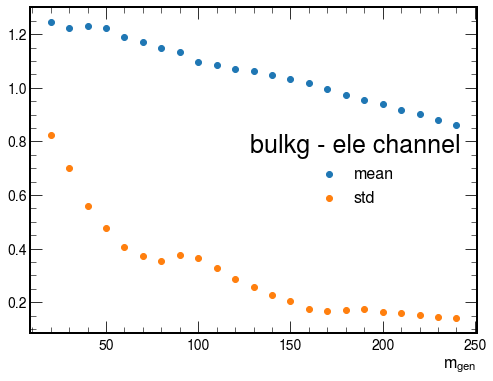

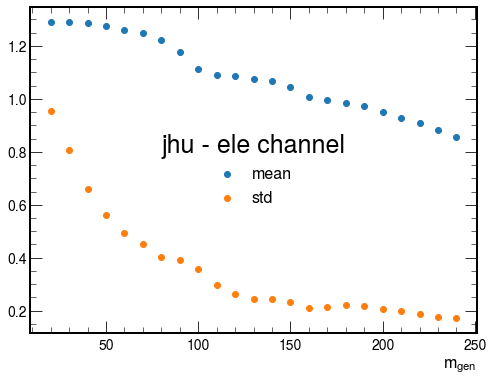

In [7]:
samples = ['bulkg', 'jhu']

ch = 'ele'

mass = {}
mean, std = {}, {}

for sample in samples:
    mass[sample] = []
    mean[sample], std[sample] = [], []        

    for X in range(20,250,10):   ### sample some gen mass values

        # select_genRes_mass
        select_genRes_mass = events[sample]['fj_genRes_mass'].array()==X

        # channel selection
        select = select_genRes_mass & (events[sample]['fj_H_VV_elenuqq'].array()==1)   

        # get mass resolution
        reco_mass = events[sample]['output'].array()[select].to_numpy()
        mres = reco_mass/X

        mass[sample].append(X)
        mean[sample].append(np.mean(mres))
        std[sample].append(np.std(mres))
        
for sample in samples:
    fig, ax = plt.subplots(figsize=(8,6))
    for var, label in [(mean[sample], 'mean'), (std[sample], 'std')]:
        ax.scatter(range(20,250,10), 
                   var, 
                   label=label, 
                  )

    ax.legend(title=f"{sample} - {ch} channel", title_fontsize=25, fontsize=16)
    ax.set_xlabel(r"$m_{gen}$", fontsize=16)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
#     ax.set_ylim(0,0.02)
#     axes[i].set_yscale('log')
    plt.savefig(f"inference_plots/{sample}_sigma_mean.pdf")     

# $m_{reg}$ for leptonic signal

In [44]:
samples = ['bulkg', 'jhu', 'hww_bulkg', 'hww_jhu']
samples = ['bulkg', 'jhu']

channels = ['ele', 'mu']

reco_mass = {}
target_mass = {}
softdrop_mass = {}

test_mgen = 140

for ch in channels:
    reco_mass[ch] = {}
    target_mass[ch] = {}
    softdrop_mass[ch] = {}

    for sample in samples:
        
        # select_genRes_mass
        if sample in ['bulkg']:
            select_genRes_mass = events[sample]['fj_genRes_mass'].array()==test_mgen
        elif sample in ['jhu']:            
            select_genRes_mass = events[sample]['fj_genRes_mass'].array()==test_mgen
        elif 'hww' in sample:
            select_genRes_mass = events[sample]['fj_genRes_mass'].array()==125
        else:
            select_genRes_mass = True
           
        # channel selection
        if ch == 'ele':
            select = select_genRes_mass & (events[sample]['fj_H_VV_elenuqq'].array()==1)   
        elif ch == 'mu':
            select = select_genRes_mass & (events[sample]['fj_H_VV_munuqq'].array()==1)

        reco_mass[ch][sample] = events[sample]['output'].array()[select].to_numpy()
        target_mass[ch][sample] = events[sample]['target_mass'].array()[select].to_numpy()
        softdrop_mass[ch][sample] = events[sample]['fj_msoftdrop'].array()[select].to_numpy()

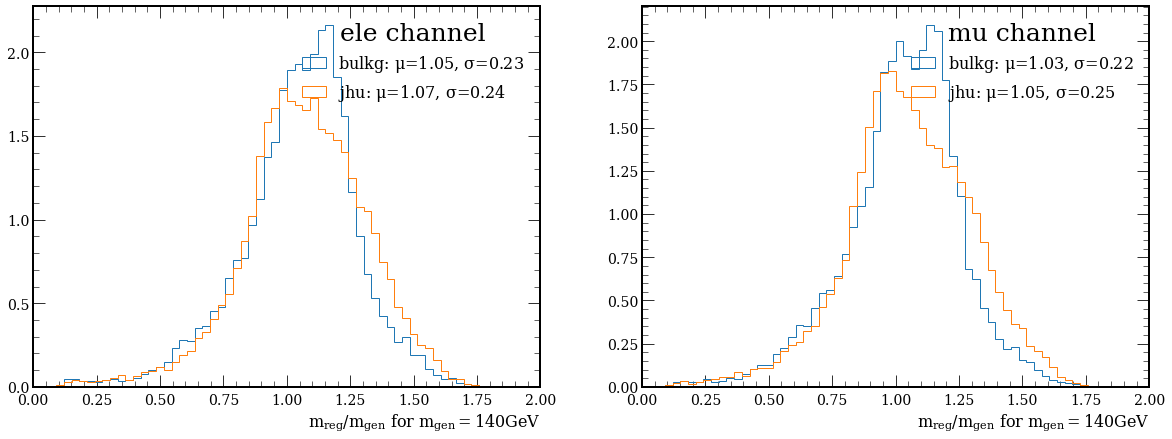

In [45]:
from matplotlib.font_manager import FontProperties

font = FontProperties()
font.set_name('Times New Roman')
plt.rcParams.update({'font.family':'serif'}) 

fig, axes = plt.subplots(ncols=2, figsize=(20,7))
for i, ch in enumerate(channels):
    for sample in samples:
   
        if sample in ['bulkg']:
            x = reco_mass[ch][sample]/test_mgen
        elif sample in ['jhu']:
            x = reco_mass[ch][sample]/test_mgen         
        elif 'hww' in sample:
            x = reco_mass[ch][sample]/125
        
        axes[i].hist(x, 
                     np.linspace(0, 3, 100), 
                     histtype='step', 
                     label=f"{sample}: $\mu$={np.mean(x):.2f}, $\sigma$={np.std(x):.2f}",
                     fill=False, 
                     linewidth=1, 
                     density=True)
    
    
    axes[i].legend(title=f"{ch} channel", title_fontsize=25, fontsize=16)
    axes[i].set_xlabel(r"$m_{reg}/m_{gen}$ for $m_{gen}="+str(test_mgen)+"GeV$", fontsize=16)
    axes[i].xaxis.set_tick_params(labelsize=14)
    axes[i].yaxis.set_tick_params(labelsize=14)    
    
    axes[i].set_xlim(0,2)    
#     axes[i].set_ylim(0,0.02)
#     axes[i].set_yscale('log')
plt.savefig(f"inference_plots/mres_{test_mgen}.pdf")

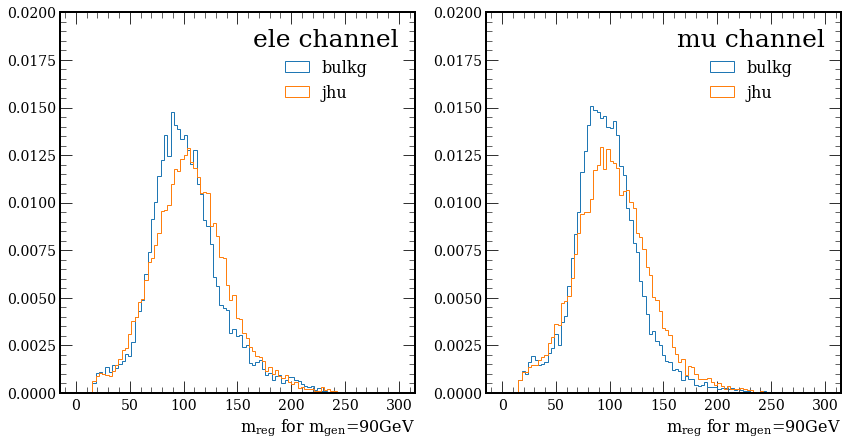

In [43]:
from matplotlib.font_manager import FontProperties

font = FontProperties()
font.set_name('Times New Roman')
plt.rcParams.update({'font.family':'serif'}) 

fig, axes = plt.subplots(ncols=2, figsize=(14,7))
for i, ch in enumerate(channels):
    for sample in samples:
        axes[i].hist(reco_mass[ch][sample], 
                     np.linspace(0, 300, 100), 
                     histtype='step', 
                     label=sample, 
                     fill=False, 
                     linewidth=1, 
                     density=True)
   
    axes[i].legend(title=f"{ch} channel", title_fontsize=25, fontsize=16)
    axes[i].set_xlabel(r"$m_{reg}$ for $m_{gen}$=90GeV", fontsize=16)
    axes[i].xaxis.set_tick_params(labelsize=14)
    axes[i].yaxis.set_tick_params(labelsize=14)
    axes[i].set_ylim(0,0.02)
#     axes[i].set_yscale('log')
plt.savefig(f"inference_plots/ch_mreg_90GeV.pdf")

# Compare different channels

In [46]:
samples = ['bulkg', 'jhu', 'hww_bulkg', 'hww_jhu']
channels = ['ele', 'mu', 'tau', '4q', '3q']

reco_mass = {}
target_mass = {}

for sample in samples:
    reco_mass[sample] = {}
    target_mass[sample] = {}

    for ch in channels:
        reco_mass[sample][ch] = {}
        target_mass[sample][ch] = {}

        # select_genRes_mass
        if sample in ['bulkg', 'jhu']:
            select_genRes_mass = events[sample]['fj_genRes_mass'].array()==90
        elif 'hww' in sample:
            select_genRes_mass = events[sample]['fj_genRes_mass'].array()==125
        else:
            select_genRes_mass = True

        # channel selection
        if ch == 'ele':
            select = select_genRes_mass & (events[sample]['fj_H_VV_elenuqq'].array()==1)  
        elif ch=='mu':
            select = select_genRes_mass & (events[sample]['fj_H_VV_munuqq'].array()==1)
        elif ch=='tau':
            select = select_genRes_mass & (events[sample]['fj_H_VV_taunuqq'].array()==1)
        elif ch=='4q':
            select = select_genRes_mass & (events[sample]['fj_H_VV_4q'].array()==1) & (events[sample]['fj_nprongs'].array()==4)
        elif ch=='3q':
            select = select_genRes_mass & (events[sample]['fj_H_VV_4q'].array()==1) & (events[sample]['fj_nprongs'].array()==3)

        reco_mass[sample][ch] = events[sample]['output'].array()[select].to_numpy()
        target_mass[sample][ch] = events[sample]['target_mass'].array()[select].to_numpy()

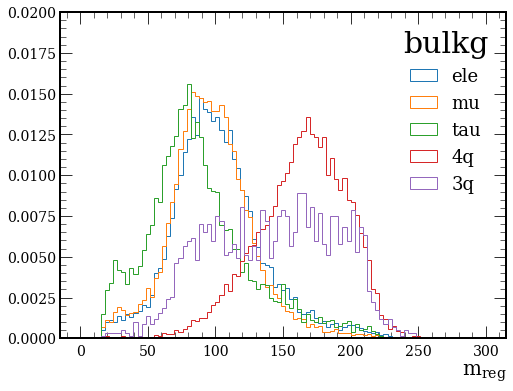

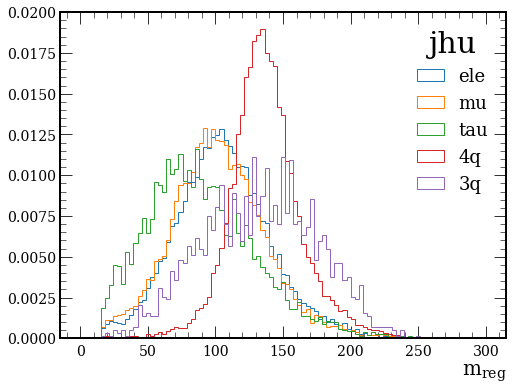

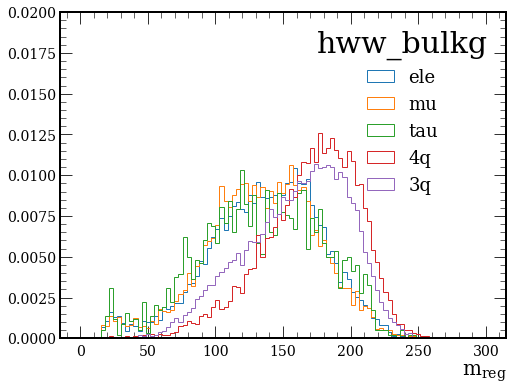

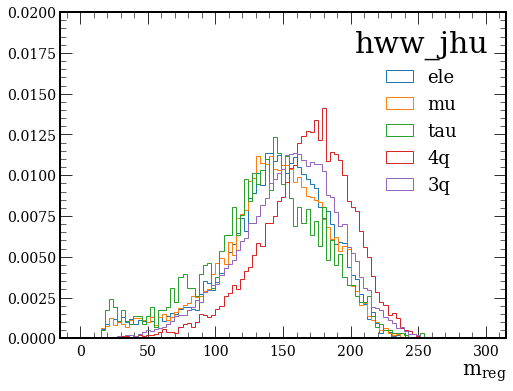

In [47]:
for sample in samples:

    fig, ax = plt.subplots(figsize=(8,6))
    for i, ch in enumerate(channels):
        ax.hist(reco_mass[sample][ch], 
                np.linspace(0, 300, 100), 
                histtype='step', 
                label=ch, 
                fill=False, 
                linewidth=1, 
                density=True)       
        
    ax.legend(title=sample, title_fontsize=30, fontsize=18)
    ax.set_xlabel(r"$m_{reg}$", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    
    ax.set_ylim(0,0.02)
    #     axes[i].set_yscale('log')
    plt.savefig(f"inference_plots/{sample}_different_channels_mreg.pdf")

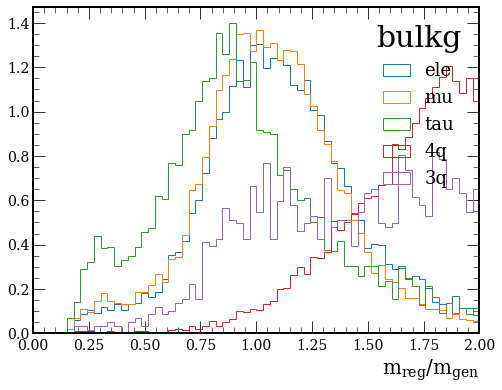

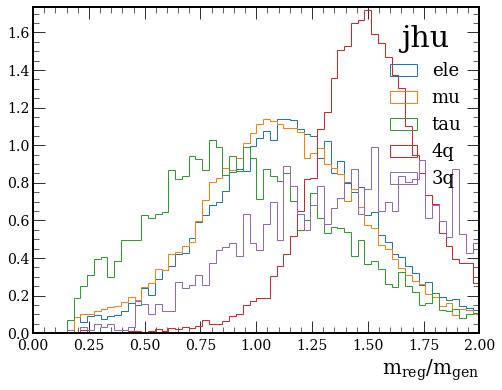

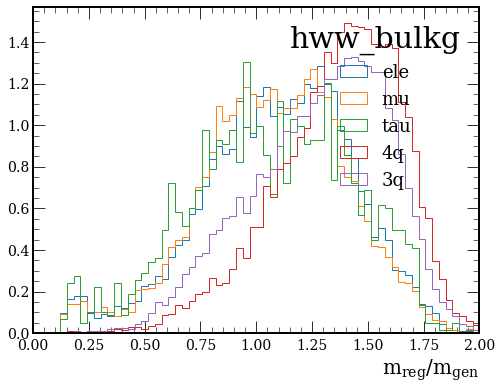

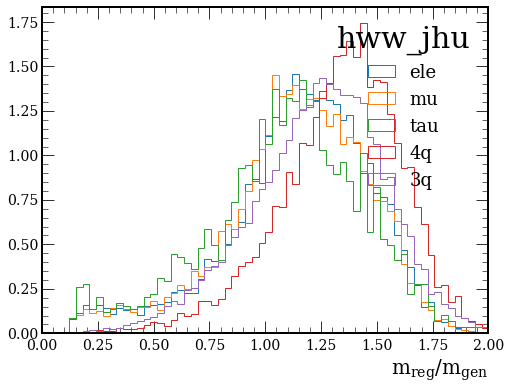

In [48]:
for sample in samples:
    fig, ax = plt.subplots(figsize=(8,6))
    
    for i, ch in enumerate(channels):
        if sample in ['bulkg', 'jhu']:
            x = reco_mass[sample][ch]/90
        elif 'hww' in sample:
            x = reco_mass[sample][ch]/125
        else:
            x = reco_mass[sample][ch]
            
        ax.hist(x, 
                np.linspace(0, 3, 100), 
                histtype='step', 
                label=ch, 
                fill=False, 
                linewidth=1, 
                density=True)
            
    ax.legend(title=sample, title_fontsize=30, fontsize=18)
    ax.set_xlabel(r"$m_{reg}/m_{gen}$", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    
    ax.set_xlim(0,2)    
    # ax.set_ylim(0,0.02)
    #     axes[i].set_yscale('log')
    plt.savefig(f"inference_plots/{sample}_different_channels_mres.pdf")

## Ratio to msd

NameError: name 'sig' is not defined

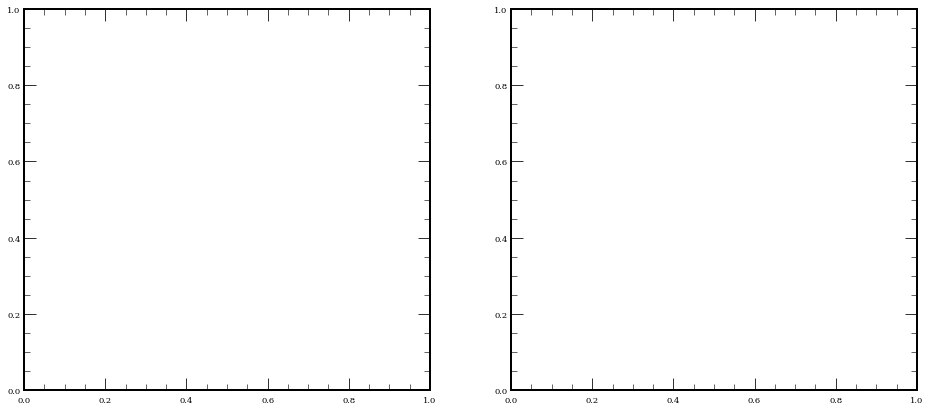

In [45]:
fig, axes = plt.subplots(ncols=2, figsize=(16,7))
for i, ch in enumerate(channels):
    for sample in sig:
        axes[i].hist(reco_mass[ch][sample]/softdrop_mass[ch][sample], np.linspace(0, 5, 100), histtype='step', label=sample, fill=False, linewidth=1, density=True)
    axes[i].legend(title=f"{ch} channel", fontsize=16)

    axes[i].set_xlabel(r"Reconstructed/softdrop mass", fontsize=16)
#     axes[i].set_ylim(0,0.02)
#     axes[i].set_yscale('log')
    # plt.savefig(f"{PATH}/top_3.pdf")

## Reco mass for 4q signal

In [ ]:
channels = ['ele', 'mu']
sig = ['bulkg', 'hww', 'jhu']
n_prongs = [3, 4]

reco_mass = {}
target_mass = {}

for ch in channels:
    reco_mass[ch] = {}
    target_mass[ch] = {}

    for sample in sig:
        
        if ch == 'ele':
            select = events[sample]['fj_H_VV_elenuqq'].array()==1    
        else:
            select = events[sample]['fj_H_VV_munuqq'].array()==1 

        if sample in ['bulkg', 'jhu']:
            select_prongs = events[sample]['fj_nprongs']==n_prong
            select = select & select_prongs

        reco_mass[ch][sample] = events[sample]['output'].array()[select].to_numpy()
        target_mass[ch][sample] = events[sample]['target_mass'].array()[select].to_numpy()

In [80]:
 events['hww'].keys()

['target_mass',
 'output',
 'fj_pt',
 'fj_eta',
 'fj_phi',
 'fj_mass',
 'fj_msoftdrop',
 'fj_genjetmass',
 'fj_genjetmsd',
 'fj_genRes_mass',
 'fj_genRes_pt',
 'fj_isQCDb',
 'fj_isQCDbb',
 'fj_isQCDc',
 'fj_isQCDcc',
 'fj_isQCDothers',
 'fj_H_VV_elenuqq',
 'fj_H_VV_munuqq',
 'fj_H_VV_taunuqq',
 'fj_nprongs',
 'met_relpt',
 'met_relphi']

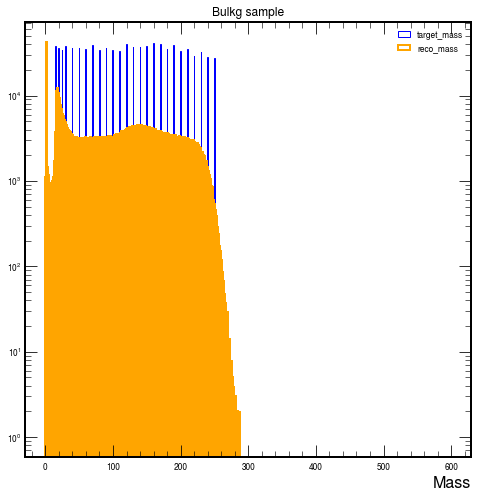

In [96]:
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(bulkg_events['target_mass'].array().to_numpy(), np.linspace(0, 600, 600), label='target_mass', fill=False, edgecolor='Blue', linewidth=1)
ax.hist(bulkg_events['output'].array().to_numpy(), np.linspace(0, 600, 600), label='reco_mass', fill=False, edgecolor='Orange', linewidth=2)

ax.legend()

ax.set_xlabel(r"Mass", fontsize=16)
ax.set_title('Bulkg sample')
ax.set_yscale('log')
# plt.savefig(f"{PATH}/top_3.pdf")

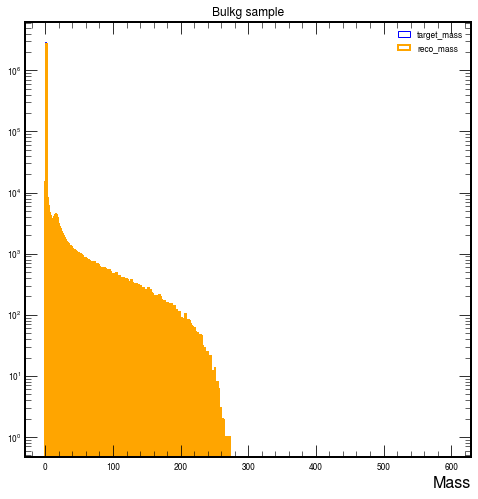

In [110]:
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(qcd_events['target_mass'].array().to_numpy(), np.linspace(0, 600, 600), label='target_mass', fill=False, edgecolor='Blue', linewidth=1)
ax.hist(qcd_events['output'].array().to_numpy(), np.linspace(0, 600, 600), label='reco_mass', fill=False, edgecolor='Orange', linewidth=2)

ax.legend()

ax.set_xlabel(r"Mass", fontsize=16)
ax.set_title('Bulkg sample')
ax.set_yscale('log')
# plt.savefig(f"{PATH}/top_3.pdf")